# Mask R-CNN图像实例分割模型迁移学习
本教程改编自[TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)。在本教程中，我们将通过微调预训练模型[Mask R-CNN](https://arxiv.org/abs/1703.06870)来完成目标检测及语义分割，数据集采用[*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/)，该数据集包括170张图片，所有图片中共有345个行人。我们会在pytorch框架下在自定义数据集上训练一个实例分割模型。
下面我们需要安装`pycocotools`，在安装`pycocotools`之前需要先安装`cython`。  
也可以在 Anaconda Prompt 命令行终端中单独执行：  
pip install cython  
pip install pycocotools

In [32]:
!pip install cython  
!pip install pycocotools

## 定义数据集

定义自己的数据集时需要继承`torch.utils.data.Dataset`类，并且实现 `__len__`和 `__getitem__`方法，其中`__getitem__`方法应该返回：
* 图像：大小为(H, W)的 PIL 图像
* 目标：包含以下键值对的字典
    * `boxes` (`FloatTensor[N, 4]`):`[x0, y0, x1, y1]`格式的`N`个边界框的坐标，`x0`和`x1`的取值范围从`0`至`W-1` ，`y0`和`y1`的取值范围从`0`至`H-1`。
    * `labels` (`Int64Tensor[N]`): 每个边界框的标签。 `0`始终代表背景类。
    * `image_id` (`Int64Tensor[1]`): 图像标识符。数据集中的所有图像的图像识别符是唯一的。
    * `area` (`Tensor[N]`): 边界框的区域。 在使用 COCO 数据集检测指标时，可使用此值来区分大、中、小边界框
    * `iscrowd` (`UInt8Tensor[N]`):  `iscrowd=True` 的实例在评估时将被忽略
    * (可选) `masks` (`UInt8Tensor[N, H, W]`): 每个对象的分割掩膜
    * (可选) `keypoints` (`FloatTensor[N, K, 3]`):对于 `N`个对象中的每一个，包含`[x, y, visibility]`格式的`K`个关键点。 `visibility=0` 表示关键点不可见。

### 为 PennFudanPed 数据集编写Dataset类

本教程打包文件中已经事先下载并解压缩 zip 文件 https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip  
数据已放在PennFudanPed子目录中。

我们具有以下文件夹结构：
```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```
下面为一张图片和其分割掩膜的示例：

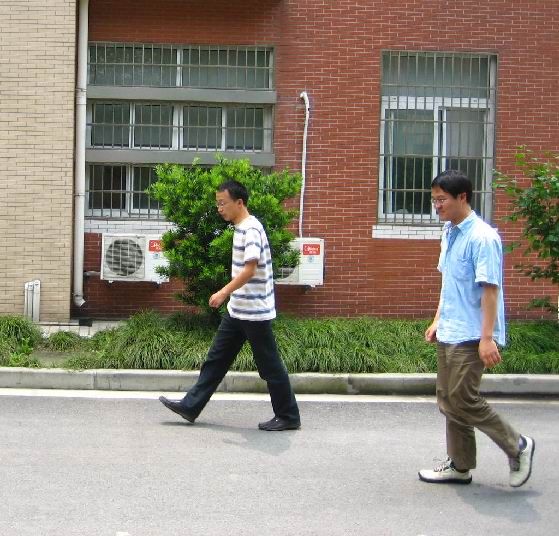

In [33]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00001.png')

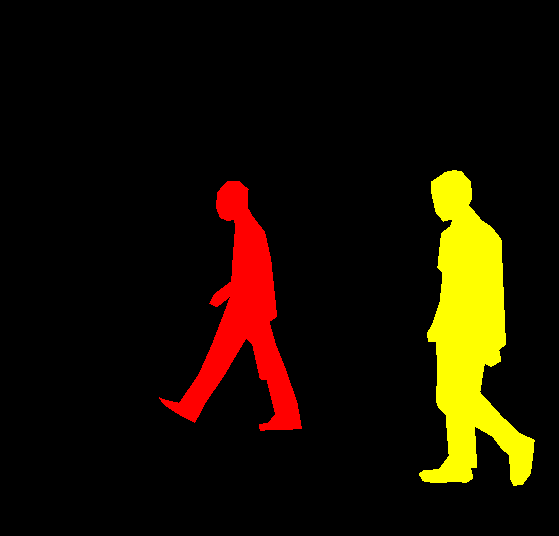

In [34]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')
#In order to make visualization easier,let's add a color palette to the mask.
mask = mask.convert("P")
#The color mode of the mask is the palette mode
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])

mask

可以看出每个图像都有一个对应的掩膜，其中每个颜色对应一个不同的实例。现在我们为PennFudan数据集编写`torch.utils.data.Dataset`类。

In [35]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

我们定义一个该类的实例：

In [36]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x23018E88CC8>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

可以看到数据集返回一个`PIL.Image`和一个包含`boxes`, `labels`和`masks`等键的字典。

## Mask R-CNN模型微调

### PennFudan 数据集的实例分割模型
我们微调Mask R-CNN预训练模型，以实现对`PennFudan`数据集的迁移学习。主干网络（backnone）采用Mask R-CNN预训练模型中的参数，目标检测分支（model.roi_heads.box_predictor）和实例分割分支(model.roi_heads.mask_predictor)为针对PennFudan数据集行人实例分割任务而重新定义的子网络。

In [37]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

模型定义好了，现在可以在PennFudan数据集上进行训练和测试了。

## 模型的训练与测试
本教程相关程序为
transforms.py: 图像处理
coco_eval.py： 数据集测试指标计算等
engine.py：模型训练测试
coco_utils.py： 数据集处理相关函数
utils.py: 相关子程序

定义数据增强函数：

In [38]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

现在数据集、模型、数据增强的部分都已经完成。在模型初始化、优化器及学习率调整策略选定后，就可以开始训练了。

In [39]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
# use less data for fast training
dataset = torch.utils.data.Subset(dataset, indices[:20])

#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
# use less data for fast testing
dataset_test = torch.utils.data.Subset(dataset_test, indices[-4:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs if we use enough number of epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

现在我们开始训练模型：

In [40]:
# let's train it for 1 epochs (more epochs need more time)
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 5 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/10]  eta: 0:16:39  lr: 0.000560  loss: 4.3455 (4.3455)  loss_classifier: 0.7496 (0.7496)  loss_box_reg: 0.2100 (0.2100)  loss_mask: 3.3653 (3.3653)  loss_objectness: 0.0172 (0.0172)  loss_rpn_box_reg: 0.0034 (0.0034)  time: 99.9009  data: 0.1336
Epoch: [0]  [ 5/10]  eta: 0:07:00  lr: 0.003335  loss: 2.2460 (2.6283)  loss_classifier: 0.3944 (0.4918)  loss_box_reg: 0.2100 (0.2585)  loss_mask: 1.3279 (1.8550)  loss_objectness: 0.0156 (0.0154)  loss_rpn_box_reg: 0.0066 (0.0074)  time: 84.1118  data: 0.1504
Epoch: [0]  [ 9/10]  eta: 0:01:24  lr: 0.005000  loss: 0.9856 (1.8838)  loss_classifier: 0.2522 (0.3658)  loss_box_reg: 0.2100 (0.2396)  loss_mask: 0.3906 (1.2494)  loss_objectness: 0.0166 (0.0193)  loss_rpn_box_reg: 0.0066 (0.0097)  time: 84.6283  data: 0.1667
Epoch: [0] Total time: 0:14:06 (84.6287 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:01:13  model_time: 18.2822 (18.2822)  evaluator_time: 0.0180 (0.0180)  time: 18.3274  data: 0.0273
Test:  [3/4] 

让我们看一下模型在测试图片上的预测结果：

In [41]:
# pick one image from the test set
img, _ = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [42]:
prediction

[{'boxes': tensor([[ 91.9913,  63.7729, 180.6301, 357.1163],
          [ 81.4517, 185.2362, 183.6058, 335.9396],
          [ 71.2627, 110.1818, 153.1330, 351.9091],
          [ 85.3000,  41.0327, 168.3108, 247.4955],
          [ 81.8615, 134.1849, 192.8426, 293.3651],
          [ 65.2117, 214.6013, 161.3649, 362.0043],
          [121.1608, 108.5578, 184.8935, 319.2314]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.2825, 0.1460, 0.1346, 0.1266, 0.0750, 0.0712, 0.0526]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [

预测结果是一个字典列表。列表的每个元素对应一个不同的图像。由于我们只有一个图像，因此列表中只有一个字典。
可以看出字典中包含 `boxes`、`labels`、`masks` 和 `scores`等信息。  
接下来将测试图像及对应的预测结果可视化出来。  
在数据增强时将`PIL.Image`转化为tensor，对图片进行归一化和翻转通道的处理，得到`[C, H, W]` 格式；在可视化时需要将其再转换为Image类。

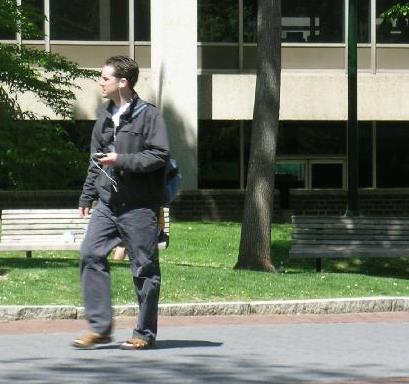

In [43]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

测试中，batch_size 为 1，当前批次中一个样本预测结果中的目标实例图像分割掩膜为prediction[0]['masks']，是以`[N, 1, H, W]`的格式呈现，其中“N”是预测的实例数量。

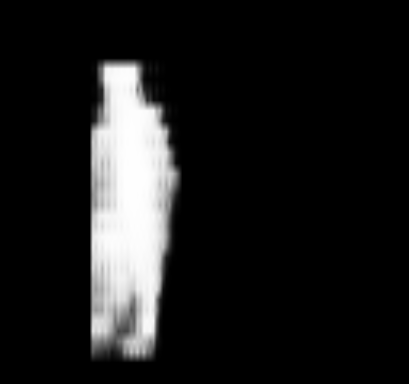

In [44]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

可以通过增加样本数和训练轮数来提高预测效果。


## 总结
在本教程中，我们通过微调COCO train2017 上预训练的 Mask R-CNN 模型，使之适用于 PennFudan 数据集的实例分割任务。